In [1]:
# import dependencies

import re
import os
import csv
import pandas as pd
from dotenv import load_dotenv
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Process 2016 Social Media Post Data

In [2]:
# Read in 2016 CSV file
posts_2016_df = pd.read_csv("../Source_Data/posts_2016.csv",)

# Display sample data
posts_2016_df.head(5)

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [3]:
# Restrict dataframe to columns of interest

# Define the columns to keep
columns_to_keep = ['id', 'handle', 'text', 'time']

# Drop all columns except the specified ones
posts_2016_df = posts_2016_df[columns_to_keep]

# Convert 'text' column to string to ensure uniform processing
posts_2016_df['text'] = posts_2016_df['text'].astype(str)

# View dataframe
posts_2016_df.head()

,id,handle,text,time
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,2016-09-28T00:22:34
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",2016-09-27T23:45:00
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,2016-09-27T23:26:40
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",2016-09-27T23:08:41
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,2016-09-27T22:30:27


In [4]:
sentiments = []

for comment in posts_2016_df['text']:
    try:
        # Ensure comment is a string
        if not isinstance(comment, str):
            raise ValueError("Comment is not a string")
            
        results = analyzer.polarity_scores(comment)
               
        sentiments.append({
            'Compound': results['compound'],
            'Positive': results['pos'],
            'Negative': results['neg'],
            'Neutral': results['neu'],
            'text': comment,
        })
    
    except Exception as e:
        print(f"Error processing comment: {e}")
        continue
    
sm16 = pd.DataFrame(sentiments)
sm16.head()

,Compound,Positive,Negative,Neutral,text
0,0.4404,0.139,0.000,0.861,The question in this election: Who can put the...
1,0.0000,0.000,0.000,1.000,"Last night, Donald Trump said not paying taxes..."
2,0.1850,0.165,0.102,0.733,Couldn't be more proud of @HillaryClinton. Her...
3,0.1376,0.128,0.101,0.771,"If we stand together, there's nothing we can't..."
4,-0.6597,0.000,0.278,0.722,Both candidates were asked about how they'd co...


In [5]:
#summary statistics sm16
sm16_stats_df = sm16.describe()
sm16_stats_df

,Compound,Positive,Negative,Neutral
count,6444.000000,6444.000000,6444.000000,6444.000000
mean,0.134630,0.148067,0.075284,0.776647
std,0.501748,0.154608,0.113624,0.160151
min,-0.965200,0.000000,0.000000,0.204000
25%,-0.180050,0.000000,0.000000,0.667000
50%,0.073750,0.122000,0.000000,0.776500
75%,0.546100,0.250000,0.136000,0.891000
max,0.973500,0.796000,0.773000,1.000000


In [6]:
# Save the 2016 summary stats to a CSV file
sm16_stats_df.to_csv('CSV_Output_Sentiment/stats_2016_df.csv', index=False)

In [7]:
# Tokenize the text and calculate sentiment for each token
def get_token_sentiments_2016(text):
    tokens16 = word_tokenize(text.lower())  # Tokenize and convert to lower case
    token_sentiments_2016 = {}
    
    for token in tokens16:
        if token.isalpha():  # Consider only alphabetic tokens
            # Analyze sentiment for each token in the context of the whole text
            sentiment_2016 = analyzer.polarity_scores(token)
            token_sentiments_2016[token] = sentiment_2016['compound']
    
    return token_sentiments_2016

In [8]:
# Apply the function to each row and expand the results into a DataFrame
def process_text_2016(text):
    token_sentiments_2016 = get_token_sentiments_2016(text)
    return token_sentiments_2016

In [9]:
# Apply the function to the 'text' column
sm16['token_sentiments_2016'] = sm16['text'].apply(process_text_2016)

# Expand token sentiments into separate columns
tokens_2016_df = pd.json_normalize(sm16['token_sentiments_2016'])

# Rename columns in tokens_df to avoid overlap with original sm16 columns
tokens_2016_df.columns = [f'token_{col}' for col in tokens_2016_df.columns]

sm16 = sm16.drop(columns=['token_sentiments_2016']).join(tokens_2016_df)

# Analyze and visualize token sentiment
sm16.head()

,Compound,Positive,Negative,Neutral,text,token_the,token_question,token_in,token_this,token_election,...,token_morocco,token_illustrates,token_duh,token_lilredfrmkokomo,token_lowell,token_iloveidevices,token_minimizing,token_dependency,token_salriccobono,token_troyconway
0,0.4404,0.139,0.000,0.861,The question in this election: Who can put the...,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0000,0.000,0.000,1.000,"Last night, Donald Trump said not paying taxes...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1850,0.165,0.102,0.733,Couldn't be more proud of @HillaryClinton. Her...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.1376,0.128,0.101,0.771,"If we stand together, there's nothing we can't...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.6597,0.000,0.278,0.722,Both candidates were asked about how they'd co...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Average sentiment score per token
average_sentiments_2016 = tokens_2016_df.mean().sort_values(ascending=False)
print("Average sentiment scores per token:")
print(average_sentiments_2016)

Average sentiment scores per token:
token_magnificently    0.6597
token_sweetheart       0.6486
token_glorious         0.6369
token_greatest         0.6369
token_best             0.6369
                        ...  
token_hell            -0.6808
token_terrorist       -0.6908
token_kill            -0.6908
token_murder          -0.6908
token_rapist          -0.7096
Length: 8496, dtype: float64


In [11]:
# Define a function to determine the candidate based on the handle
def determine_candidate_from_handle(handle):
    handle = handle.lower()  # Convert handle to lower case for case-insensitive comparison
    
    # Define patterns for combined keywords
    democrat_keywords = ['hillaryclinton']
    republican_keywords = ['realdonaldtrump']
    
    # Check if any of the Democrat patterns are present in the handle
    if any(keyword in handle for keyword in democrat_keywords):
        return 'Democrat'
    
    # Check if any of the Republican patterns are present in the handle
    elif any(keyword in handle for keyword in republican_keywords):
        return 'Republican'
    
    # Return 'Unknown' if no patterns are matched
    else:
        return 'Unknown'

In [12]:
# Apply the function to the 'handle' column to create/update the 'candidate' column
posts_2016_df['candidate'] = posts_2016_df['handle'].apply(determine_candidate_from_handle)

# Verify the result
posts_2016_df.head()

,id,handle,text,time,candidate
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,2016-09-28T00:22:34,Democrat
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",2016-09-27T23:45:00,Democrat
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,2016-09-27T23:26:40,Democrat
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",2016-09-27T23:08:41,Democrat
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,2016-09-27T22:30:27,Democrat


In [13]:
# Count the number of 'Unknown' entries in the 'candidate' column
unknown_count = posts_2016_df['candidate'].value_counts().get('Unknown', 0)

print(f"Number of 'Unknown' entries: {unknown_count}")

Number of 'Unknown' entries: 0


In [14]:
# Merge sm16 with posts_2016_df on the 'text' column to add 'candidate'
sm16_with_candidates = pd.merge(sm16, posts_2016_df[['text', 'candidate']], on='text', how='left')

# View dataframe
sm16_with_candidates.head()

,Compound,Positive,Negative,Neutral,text,token_the,token_question,token_in,token_this,token_election,...,token_illustrates,token_duh,token_lilredfrmkokomo,token_lowell,token_iloveidevices,token_minimizing,token_dependency,token_salriccobono,token_troyconway,candidate
0,0.4404,0.139,0.000,0.861,The question in this election: Who can put the...,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Democrat
1,0.0000,0.000,0.000,1.000,"Last night, Donald Trump said not paying taxes...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Democrat
2,0.1850,0.165,0.102,0.733,Couldn't be more proud of @HillaryClinton. Her...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Democrat
3,0.1376,0.128,0.101,0.771,"If we stand together, there's nothing we can't...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Democrat
4,-0.6597,0.000,0.278,0.722,Both candidates were asked about how they'd co...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Democrat


In [15]:
# Save the 2016 sentiment and cnadidate by post to a CSV file
sm16_with_candidates.to_csv('CSV_Output_Sentiment/sent_and_cand_by_post_2016.csv', index=False)

In [16]:
# Identify all token columns
token_columns = [col for col in sm16_with_candidates.columns if col.startswith('token_')]

# Ensure that the value name does not match any existing column names
# Checking for potential conflicts
existing_columns = set(sm16_with_candidates.columns)
unique_value_name = 'token_count' if 'token_count' not in existing_columns else 'token_count_unique'

# Reshape the DataFrame from wide to long format for tokens
tokens_long_df = sm16_with_candidates.melt(
    id_vars=['text', 'candidate'], 
    value_vars=token_columns,
    var_name='token',
    value_name=unique_value_name
)

# Filter out rows where token_count is 0
tokens_long_df = tokens_long_df[tokens_long_df[unique_value_name] > 0]

# Melt sentiment columns to long format
sentiment_columns = ['Compound', 'Positive', 'Negative', 'Neutral']
sentiments_long_df = sm16_with_candidates.melt(
    id_vars=['text', 'candidate'],
    value_vars=sentiment_columns,
    var_name='sentiment_type',
    value_name='sentiment_value'
)

# Merge token presence with sentiment values on 'text' and 'candidate'
merged_df = tokens_long_df.merge(sentiments_long_df, on=['text', 'candidate'])

# Aggregate sentiment values by candidate and token
token_sentiments_2016 = merged_df.groupby(['candidate', 'token']).agg({
    'sentiment_value': 'mean',
    unique_value_name: 'sum'
}).reset_index()

# Verify the result
token_sentiments_2016.head()

,candidate,token,sentiment_value,token_count_unique
0,Democrat,token_ability,0.321694,5.0912
1,Democrat,token_accept,0.376663,15.2720
2,Democrat,token_accepted,0.303513,4.3712
3,Democrat,token_accepting,0.176000,1.5272
4,Democrat,token_accepts,0.355375,2.5456


In [17]:
# Aggregate sentiment scores by candidate

# Calculate weighted average sentiment score for each candidate
# This step uses the 'sentiment_value' and 'token_count_unique' columns
candidate_sentiments = token_sentiments_2016.groupby('candidate').apply(
    lambda df: (df['sentiment_value'] * df['token_count_unique']).sum() / df['token_count_unique'].sum()
).reset_index(name='average_sentiment')

# Display the aggregated sentiment scores
print("Average sentiment scores by candidate:")
print(candidate_sentiments)

Average sentiment scores by candidate:
    candidate  average_sentiment
0    Democrat           0.364082
1  Republican           0.403678


In [18]:
# Combine sentiment scores with other features

# Merge candidate sentiments with posts_2016_df
# Make sure to use the 'candidate' column for merging
sent_2016_df = pd.merge(posts_2016_df, candidate_sentiments, on='candidate', how='left')

# Display the final DataFrame with the required columns
sent_2016_df = sent_2016_df[['id', 'text', 'time', 'candidate', 'average_sentiment']]
sent_2016_df.head()

,id,text,time,candidate,average_sentiment
0,780925634159796224,The question in this election: Who can put the...,2016-09-28T00:22:34,Democrat,0.364082
1,780916180899037184,"Last night, Donald Trump said not paying taxes...",2016-09-27T23:45:00,Democrat,0.364082
2,780911564857761793,Couldn't be more proud of @HillaryClinton. Her...,2016-09-27T23:26:40,Democrat,0.364082
3,780907038650068994,"If we stand together, there's nothing we can't...",2016-09-27T23:08:41,Democrat,0.364082
4,780897419462602752,Both candidates were asked about how they'd co...,2016-09-27T22:30:27,Democrat,0.364082


In [19]:
# Edit the time column to display only the year

# Ensure the 'time' column is in datetime format
sent_2016_df['time'] = pd.to_datetime(sent_2016_df['time'], errors='coerce')

# Extract the year from the datetime column and update the 'time' column
sent_2016_df['time'] = sent_2016_df['time'].dt.year

# Display the modified DataFrame
sent_2016_df.head()

,id,text,time,candidate,average_sentiment
0,780925634159796224,The question in this election: Who can put the...,2016,Democrat,0.364082
1,780916180899037184,"Last night, Donald Trump said not paying taxes...",2016,Democrat,0.364082
2,780911564857761793,Couldn't be more proud of @HillaryClinton. Her...,2016,Democrat,0.364082
3,780907038650068994,"If we stand together, there's nothing we can't...",2016,Democrat,0.364082
4,780897419462602752,Both candidates were asked about how they'd co...,2016,Democrat,0.364082


In [20]:
# Save the final 2016 dataFrame for use in PostGres to a CSV file
sent_2016_df.to_csv('CSV_Output_Sentiment/sent_info_for_db_2016.csv', index=False)

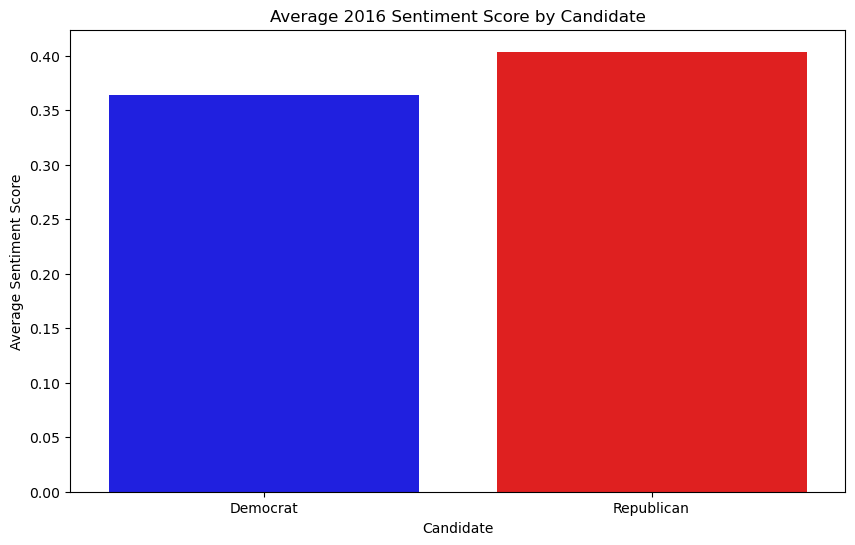

In [21]:
# Plot average sentiment scores for each candidate

# Define color palette to match the colleague's visual
color_palette = {'Democrat': 'blue', 'Republican': 'red'}

# Create a seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='candidate', y='average_sentiment', data=candidate_sentiments, palette=color_palette)

# Add labels and title
plt.xlabel('Candidate')
plt.ylabel('Average Sentiment Score')
plt.title('Average 2016 Sentiment Score by Candidate')
plt.savefig('../Visualizations/avg_sent_by_cand_2016.png')

# Show the plot
plt.show()

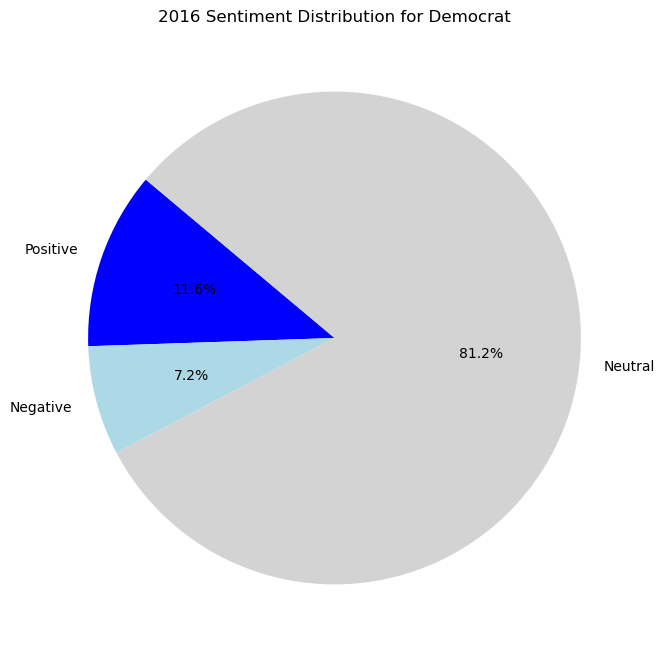

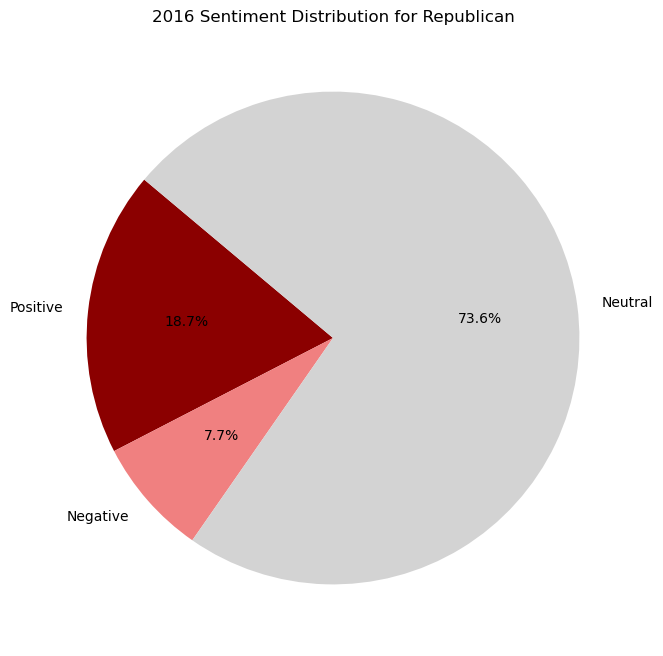

In [22]:
# Display positive, negative, and neutral sentiment scores by candidate

# Aggregate sentiment scores by candidate
sentiment_summary = sm16_with_candidates.groupby('candidate')[['Positive', 'Negative', 'Neutral']].sum().reset_index()

# Define color palette for sentiments
color_palettes = {
    'Democrat': {
        'Positive': 'blue',  # Replace 'strongblue' with actual color code
        'Negative': 'lightblue',   # Replace 'palerblue' with actual color code
        'Neutral': 'lightgrey'
    },
    'Republican': {
        'Positive': 'darkred',     # Strong red
        'Negative': 'lightcoral',  # Pale red
        'Neutral': 'lightgrey'
    }
}

# Define a function to plot a pie chart for a given candidate
def plot_pie_chart(candidate, positive, negative, neutral):
    sentiments = [positive, negative, neutral]
    labels = ['Positive', 'Negative', 'Neutral']
    colors = color_palettes.get(candidate, {
        'Positive': 'grey',
        'Negative': 'grey',
        'Neutral': 'grey'
    }).values()
    
    plt.figure(figsize=(8, 8))
    plt.pie(sentiments, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'2016 Sentiment Distribution for {candidate}')
    plt.savefig('../Visualizations/pos_neg_neut_by_party_2016.png')
    plt.show()

# Plot pie charts for each candidate
for index, row in sentiment_summary.iterrows():
    candidate = row['candidate']
    positive = row['Positive']
    negative = row['Negative']
    neutral = row['Neutral']
    plot_pie_chart(candidate, positive, negative, neutral)
